# Tutorial 2A: Simulating Diffusion Across A Synapse

© 2018 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT) 

--- 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns
import cbbtn_utilities as cb
sns.set()
sns.set_context('talk')
%matplotlib inline

In this tutorial, we will return to our tools of numerical integration to examine the distribution of mRNA per cell from a constitutively expressing promoter.    

##  The Dynamics of Constitutive Expression

Before we examine the mRNA distribution, let's examine the mean behavior of the system. By definition, a constitutive gene is one whose expression is unregulated. A cartoon for the constitutive expression is shown below.


Here, we have mathematized the cartoon as well. We say that mRNA is produced from this gene at some rate $r$ and is then degraded at a rate $\gamma$. While the production rate of mRNA is independent of the number of mRNAs present in the cell, the number of mRNAs lost to degradation is dependent on this number. We can write a differential equation describing the behavior of the mean as  

$$
{dm \over dt} = r - \gamma m. \tag{1}
$$

While we will sove this equation numerically, we can very easily solve for the mean number of mRNAs at *steady state*, or when an equal number of mRNAs are produced and degraded at each time step. Mathematically, we can say that steady state is reached when the differential equation in Eq. 1 is equal to 0,

$$
{dm \over dt} = r - \gamma m = 0. \tag{2}
$$

The steady-state mean number of mRNAs can be found by solving Eq. 2 for $m$, 

$$
m = {r \over \gamma}. \tag{3}
$$

Therefore, with knowledge of the production rate $r$ and the degradation rate $\gamma$, we can very easily find the steady-state level of gene expression. Let's explore the dynamics of the mean expression using our superpower of numerical integration.

## Numerically Integrating $dm \over dt$

Much as we did in [tutorial 1](t0a_numerical_integration.html), we can rewrite Eq. 1 by calculating the number of mRNAs after a small step forward in time $\Delta t$ as

$$
m(t + \Delta t) = \overbrace{m(t)}^\text{previous} + \underbrace{r \Delta t}_\text{production} - \overbrace{\gamma \Delta t m(t)}^\text{degradation}. \tag{4}
$$

Using the Fowrard Euler method, let's integrate Eq. 4 for several different starting conditions and see if we end up at the steady state expression level, $r / \gamma$. To begin, we will define some parameters.

In [2]:
# Define parameters for the integration. 
r = 1 # Production rate in 1 mRNA / min
gamma = 1 / 3 # Degradation rate in inverse minutes. 
dt = 1 / 30 # Time step smaller than the degradation and production rates. 
total_time = 20 # Total time of the integration in minutes. 
n_steps = int(total_time / dt) # The total number of time steps to be taken. 


# Compute the theoretical steady-state value
steady_state = r / gamma
print("The predicted steady state mean value is %s mRNAs per cell." %(steady_state))

The predicted steady state mean value is 3.0 mRNA's per cell.


With these parameters defined, we can set up our storage vector and set some initial conditions. For expediency, we will run all three integrations at the same time! 

In [7]:
# Set up the storage vectors. This will be n_steps columns by n_sim rows.
n_sim = 3 # The number of unique starting positions
m_t = np.zeros((n_sim, n_steps))

# Set the initial conditions. We will start above, below, and at the steady state value. 
m_t[1, 0] = steady_state + 5 # Above the steady state value
m_t[2, 0] = steady_state # At steady state

# Loop through each time step and execute the integration. 
for i in range(1, n_steps):
    # Compute the change in mRNA number.
    dm = r * dt - gamma * dt * m_t[:, i - 1]
    
    # Update the total number of mRNA
    m_t[:, i] = m_t[:, i-1] + dm 

Now, let's plot the three integrations as well as a horizontal line at the steady state value.  

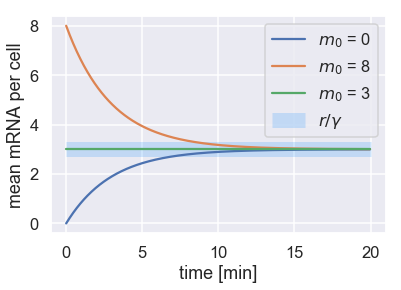

In [14]:
# Set up a time vector. 
time_range = np.arange(0, total_time, dt)

# Plot the three integrations. 
plt.plot(time_range, m_t[0, :], label='$m_0$ = %s' %int(m_t[0, 0]))
plt.plot(time_range, m_t[1, :], label='$m_0$ = %s' %int(m_t[1, 0]))
plt.plot(time_range, m_t[2, :], label='$m_0$ = %s' %int(m_t[2, 0]))

# Plot a transparent line at the steady state value. 
plt.hlines(steady_state, 0, total_time, color='dodgerblue', alpha=0.2, 
           linewidth=15, label='$r / \gamma$')

# Add labels like a good scientist. 
plt.xlabel('time [min]')
plt.ylabel('mean mRNA per cell')
plt.legend()

Here we see that no matter where we start, the system will reach the steady state value. If we start *at* the steady state value, the system will not change! While this is certainly an accomplishment, we are just solving for the mean -- this says nothing about the *distribution* of mRNAs per cell. As we discussed in our [tutorial on random walks](t03_stochastic_simulations.html), The distribution of a process is often more informative than knowing only the mean. 

## Computing the mRNA Distribution

Rather than computing for the mean number of mRNA per cell, we can compute the full distribution, meaning we want to solve for the probability $P(m, t)$ for a range of mRNAs. Analytically, we would solve this for the probability across all mRNA space $[0, \infty)$. Again turning to our numerical formulation, we can write the probabability of finding $m$ mRNAs at time $t + \Delta t$ as

$$
P(m, t + \Delta t) = \overbrace{P(m, t)}^\text{previous} + \underbrace{r  \Delta t  P(m - 1, t) + \gamma(m+1)  \Delta t  P(m + 1, t)}_\text{production} - \overbrace{r  \Delta t P(m, t) - \gamma (m) \Delta t P(m, t)}^\text{degradation}. \tag{5}
$$

Notice that we have $\gamma$ present in *both* our production and degradation terms! We can gain an mRNA by either producing one at a rate $r$, given the probability of having $m-1$ mRNAs or we can gain probability by *degrading* an mRNA, given the probability of having $m+1$ mRNAs. 

With Eq. 5 well stated, we can begin our integration. Much as in our [tutorial on chemical master equations](t04_chemical_master_equations.html), we need to be careful about our boundary conditions. We can't integrate over an infinite number of mRNAs, so we will impose a large upper limit of the mRNAs that we can have. We will set this large enough such that we don't actually reach the end. Below, we start by defining some dimensional parameters.

In [44]:
# Change the total time 
total_time = 20
n_steps = int(total_time / dt)
# Define the number of mRNAs we will integrate over
max_mRNA = 20

# Set up the matrix to store the probability of mRNAs
prob = np.zeros((max_mRNA, n_steps))

# Set the initial condition of maximal probability at 0 mRNA. 
prob[0, 0] = 1

With our matrix defined, we can integrate, assuming we have no mRNA to begin with

In [45]:
# Loop over each time point. 
for t in range(1, n_steps):
    # Compute the cases for the boundary  conditions. 
    prob[0, t] = prob[0, t-1] + gamma * dt * prob[1, t-1] - r * dt * prob[0, t-1]
    prob[-1, t] = prob[-1, t-1] + r * dt * prob[-2, t-1] - gamma * (max_mRNA) * dt * prob[-1, t-1]
    
    # Iterate through all of the mRNAs and properly integrate. 
    for m in range(1, max_mRNA - 1):
        # Compute the production terms. 
        pm_add = r * dt * prob[m-1, t-1] + gamma * (m + 1) * dt * prob[m+1, t-1]
        
        # Compute the degradation term
        pm_sub = r * dt * prob[m, t-1] + gamma * m * dt * prob[m, t-1]
        
        # Update the probability
        prob[m, t] = prob[m, t-1] + pm_add - pm_sub
    

And just like that, the integration is finished! Let's look at the time evolution of this distribution using a three dimensional bar plot. 

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x1c21a87668>)

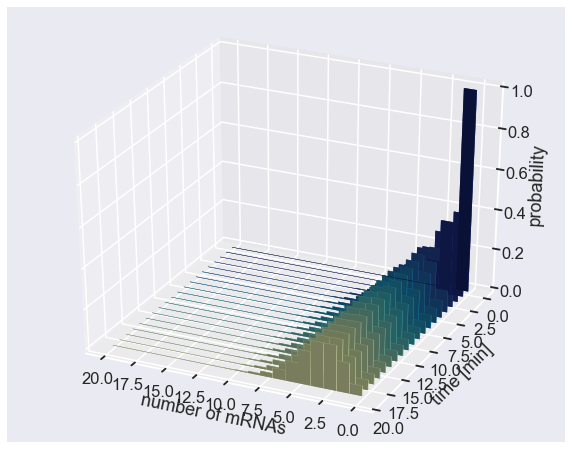

In [53]:
# Make a three dimensional bar plot of the time evolution. 
cb.bar_plot(prob, 20, dy=dt, x_label='number of mRNAs', y_label='time [min]', z_label='probability')

Much as we saw when we examined the dynamics of the mean, we see that after some time, we reach the steady state 